<a href="https://colab.research.google.com/github/annkamsk/ASD-problems/blob/master/Ass2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
%matplotlib inline

## UNet definition

In [0]:
class DownConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DownConv, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        seq = [
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # nn.BatchNorm2d(out_channels),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1),
                nn.ReLU()
                # nn.BatchNorm2d(out_channels)
              ]
        self.seq = nn.Sequential(*seq)

    def forward(self, x):
        return self.seq(x)


class UpConv(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 up_mode='transpose'):
        super(UpConv, self).__init__()

        # up conv
        self.up_mode = up_mode
        if up_mode == 'transpose':
          self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        else:
          self.up = nn.Sequential(
                nn.Upsample(mode='bilinear', scale_factor=2),
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1))
        self.conv_seq = nn.Sequential(
            nn.Conv2d(2 * out_channels,
                     out_channels,
                     kernel_size=3,
                     stride=1,
                     padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels,
                out_channels,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.ReLU()  
        )

    def forward(self, from_down, from_up):
        from_up = self.up(from_up)
        out = torch.cat((from_up, from_down), 1)
        return self.conv_seq(out)

class UNet(nn.Module):
    def __init__(self, num_classes, in_channels=3, depth=5,
                 wf=6, up_mode='transpose'):
        """
            num_classes: nr of output channels
            in_channels: int, number of channels in the input tensor. Default is 3 for RGB images.
            depth: int, number of MaxPools in the U-Net.
            wf: number of convolutional filters for the first conv is 2**Wf
            up_mode: type of upconvolution. 'transpose' 
              or 'upsample' for nearest neighbour upsampling.
        """
        super(UNet, self).__init__()
        self.up_mode = up_mode
        self.num_classes = num_classes
        self.in_channels = in_channels
        self.wf = wf
        self.depth = depth

        # create the encoder pathway and add to a list
        self.down_path = nn.ModuleList()
        for i in range(depth):
          ins = self.in_channels if i == 0 else outs
          outs = 2 ** (self.wf + i)
          self.down_path.append(DownConv(ins, outs))

        # create the decoder pathway and add to a list
        # - careful! decoding only requires depth-1 blocks
        self.up_path = nn.ModuleList()
        for i in range(depth - 1):
          ins = outs 
          outs = ins // 2
          self.up_path.append(UpConv(ins, outs, up_mode))

        self.final = nn.Conv2d(outs, num_classes, kernel_size=1)


    def forward(self, x):
        encoder_outs = []
        for i, module in enumerate(self.down_path):
            x = module(x)
            if i < len(self.down_path) - 1:
              encoder_outs.append(x)
              x = F.max_pool2d(x, 2)

        for i, module in enumerate(self.up_path):
          from_down = encoder_outs[-i-1]
          x = module(from_down, x)

        # No softmax is used. This means you need to use
        # nn.CrossEntropyLoss in your training script,
        # as this module includes a softmax already.
        x = self.final(x)
        return x

## Load data

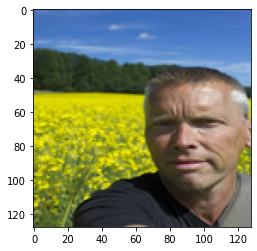

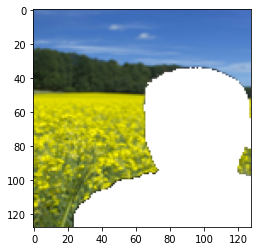

In [3]:
class MyDataset(Dataset):
  def __init__(self, data, mask, transform=None):
    self.data = torch.from_numpy(data)
    self.mask = torch.from_numpy(mask).long()
    self.target = torch.from_numpy(np.array([self.__encode__(m) for m in mask]))
    self.transform = transform

  def __getitem__(self, idx):
    x = self.data[idx]
    y = self.target[idx]

    if self.transform:
      x = self.transform(x)
    return x, y

  def __len__(self):
    N, _, _, _ = self.data.shape
    return N

  def __encode__(self, mask):
    H, W, _ = mask.shape
    target = np.zeros((H, W))
    target = (mask[:, :, 0] == 255)
    return target.astype(int)        

class Params:
    img_size = (128, 128)
    bs = 2
    num_workers = 4
    lr = 0.001
    epochs = 3
    unet_depth = 5
    wf = 3
    log_interval = 70.0 # less then len(train_dl)

train_path = '/content/drive/My Drive/MIM/dl_lab/ass2/gsn_img_uint8.npy'
test_path = '/content/drive/My Drive/MIM/dl_lab/ass2/test_gsn_image.npy'
train_mask = '/content/drive/My Drive/MIM/dl_lab/ass2/gsn_msk_uint8.npy'
test_mask_path = '/content/drive/My Drive/MIM/dl_lab/ass2/test_gsn_mask.npy'
best_model_path = '/content/model.pth'

trains = np.load(train_path)
masks = np.load(train_mask)
tests = np.load(test_path)
test_masks = np.load(test_mask_path)

train_dataset = MyDataset(trains, masks)
test_dataset = MyDataset(tests, test_masks)
trainloader = DataLoader(train_dataset, 
                         batch_size=Params.bs, 
                         shuffle=True, 
                         pin_memory=torch.cuda.is_available(),
                         num_workers=Params.num_workers)

testloader = DataLoader(test_dataset,
                        batch_size=Params.bs,
                        shuffle=False,
                        pin_memory=torch.cuda.is_available(),
                        num_workers=Params.num_workers)

def imshow(img, target):
  for k in range(img.size()[2]):
    for i in range(img.size()[0]):
      for jj in range(img.size()[1]):
        if target[i, jj] == 1:
          img[i, jj, k] = 255
  plt.imshow(img)
  plt.show()

images, targets = iter(trainloader).next()
plt.imshow(images[0])
plt.show()
imshow(images[0], targets[0])

## Train

In [0]:
def get_loss(dataloader, model):
    loss = 0
    total_train = 0
    correct_train = 0
    train_accuracy = 0
    for img, mask in dataloader:
        img, mask = Variable(np.transpose(img.float(), (0,3,1,2))).cuda(), Variable(mask).cuda()
        output = model(img)
        loss += F.cross_entropy(output, mask).item()
        _, predicted = torch.max(output.data, 1)
        total_train += mask.nelement()
        correct_train += predicted.eq(mask.data).sum().item()
        train_accuracy = max(train_accuracy, 100 * correct_train / total_train)
    loss = loss / len(dataloader)
    return loss, train_accuracy

In [16]:
model = UNet(num_classes=2, depth=Params.unet_depth, wf=Params.wf)
model.cuda()

def train():
  it = 0
  iters = []
  losses = []
  test_losses = []
  min_loss = np.inf

  criterion = nn.CrossEntropyLoss()
  optim = torch.optim.Adam(model.parameters(), lr=Params.lr)
  
  model.train()
  for epoch in range(Params.epochs):
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    for i, (img, mask) in enumerate(trainloader):
      img = Variable(np.transpose(img.float(), (0,3,1,2))).cuda() # [N, 3, H, W] <- [2, 128, 128, 3])
      mask = Variable(mask).cuda() # [N, H, W]
      output = model(img) # [N, 1, 128, 128]
      loss = criterion(output, mask)
      
      optim.zero_grad()
      loss.backward()
      optim.step()

      curr_loss = loss.item()
      running_loss += curr_loss
      if (i + 1) % Params.log_interval == 0:
        it += Params.log_interval * Params.bs
        iters.append(it)
        losses.append(curr_loss)

        print('[%d, %5d] Train loss: %.3f' %
                      (epoch + 1, i + 1, running_loss / Params.log_interval))
        running_loss = 0.0

        model.eval()
        test_loss, accuracy = get_loss(testloader, model)
        model.train()
        test_losses.append(test_loss)
        print('Test accuracy: %d %%' %
                      (accuracy))
        if test_loss < min_loss:
          min_loss = test_loss
          torch.save(model.state_dict(), best_model_path)

  model.eval()
  test_loss = get_loss(testloader, model)
  if test_loss < min_loss:
    torch.save(model.state_dict(), best_model_path)

  return iters, losses, test_losses
          
iters, losses, test_losses = train()

[1,    70] Train loss: 0.615
Test accuracy: 67 %
[1,   140] Train loss: 0.592
Test accuracy: 79 %
[1,   210] Train loss: 0.464
Test accuracy: 82 %
[1,   280] Train loss: 0.447
Test accuracy: 80 %
[1,   350] Train loss: 0.411
Test accuracy: 84 %
[1,   420] Train loss: 0.466
Test accuracy: 84 %
[1,   490] Train loss: 0.413
Test accuracy: 82 %
[1,   560] Train loss: 0.381
Test accuracy: 85 %
[1,   630] Train loss: 0.373
Test accuracy: 89 %
[1,   700] Train loss: 0.374
Test accuracy: 83 %
[1,   770] Train loss: 0.379
Test accuracy: 89 %
[1,   840] Train loss: 0.395
Test accuracy: 84 %
[1,   910] Train loss: 0.342
Test accuracy: 85 %
[1,   980] Train loss: 0.356
Test accuracy: 85 %
[2,    70] Train loss: 0.349
Test accuracy: 85 %
[2,   140] Train loss: 0.340
Test accuracy: 90 %
[2,   210] Train loss: 0.341
Test accuracy: 86 %
[2,   280] Train loss: 0.310
Test accuracy: 87 %
[2,   350] Train loss: 0.344
Test accuracy: 90 %
[2,   420] Train loss: 0.334
Test accuracy: 87 %
[2,   490] Train los

TypeError: ignored

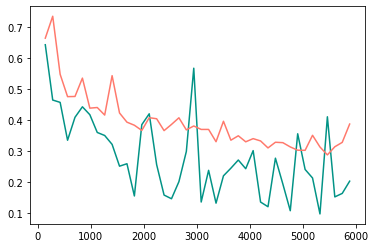

In [17]:
plt.plot(iters, losses, color='xkcd:teal')
plt.plot(iters, test_losses, color='xkcd:salmon')
plt.show()